In [17]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score as bmac
from sklearn.metrics import confusion_matrix 

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

In [3]:
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="id,y",  comments='')

In [4]:
X_train_file = 'X_train.csv'
y_train_file = 'y_train.csv'
X_test_file  = 'X_test.csv'

labels_df = pd.read_csv(y_train_file)
bare_df   = pd.read_csv(X_train_file)
test_df   = pd.read_csv(X_test_file)

bare_df.insert(0,'y',labels_df['y'])

labels_df = labels_df.set_index('id')
bare_df   = bare_df  .set_index('id')
test_df   = test_df  .set_index('id')

print('bare_df.shape =', bare_df.shape)
print('test_df.shape  =', test_df.shape)
print('y distribution: ')
print(bare_df['y'].value_counts())
print('We are told that \"Test set has the same class imbalance as the training set.\"')

bare_df.shape = (4800, 1001)
test_df.shape  = (4100, 1000)
y distribution: 
1    3600
2     600
0     600
Name: y, dtype: int64
We are told that "Test set has the same class imbalance as the training set."


In [53]:
def mean_std_normalise(df):
    return (df-df.mean())/df.std()

def min_max_normalise(df):
    return (2*df-df.min()-df.max())/(df.max()-df.min())

# I have this in a function bacause it makes it easy to 
# make a new train/test split and normalise etc
def preprocess(split):
    
    #Normalizing and preparing feature and label matrices
    
    nrm_df = mean_std_normalise(bare_df.drop(columns='y'))
    nrm_df['y'] = bare_df['y']
    # dividing X, y into train and test data 
    if split == 0.0:
        df_train = nrm_df
        
    else:
        df_train, df_test = train_test_split(nrm_df, test_size = split)

    X_train = df_train.drop(columns='y').values
    y_train = df_train['y'].values
    X_AML   = mean_std_normalise(test_df).values
    n_AML, _ = np.shape(X_AML)
    weights={0:1/.125, 1:1/.75, 2:1/.125}

    n_train = len(y_train)
    print("train shape = ", np.shape(X_train))

    if split == 0.0:
        X_test = np.array([[]])
        y_test = np.array([])
        n_test = 0
    else:
        X_test = df_test.drop(columns='y').values
        y_test = df_test['y'].values
        n_test = len(y_test)
        print("test shape  = ", np.shape(X_test))
        print()
        print('n0test = %.1f%%'%(100/n_test*np.sum((y_test == 0))))
        print('n1test = %.1f%%'%(100/n_test*np.sum((y_test == 1))))
        print('n2test = %.1f%%'%(100/n_test*np.sum((y_test == 2))))
    print()

    print('n0train = %.1f%%'%(100/n_train*np.sum((y_train == 0))))
    print('n1train = %.1f%%'%(100/n_train*np.sum((y_train == 1))))
    print('n2train = %.1f%%'%(100/n_train*np.sum((y_train == 2))))
    print()
    return X_train, y_train, n_train, weights, X_test, y_test, n_test, X_AML, n_AML

In [54]:
test_ratio = 0
X_train, y_train, n_train, weights, X_test, y_test, n_test, X_AML, n_AML = preprocess(test_ratio)
samwe = [weights[int(yi)] for yi in y_test] 

train shape =  (4800, 1000)

n0train = 12.5%
n1train = 75.0%
n2train = 12.5%



In [55]:
n_samples = len(y_train)+len(y_test)

tuned_parameters = [
                    {'kernel': ['poly'], 
                     'gamma' : [7e-5],
                     'degree': [4],  
                     'C'     : [1],
                     'coef0' : [1],
                    },
                   ]

# set probability to true if you want to get confidence estimates later
# (makes fitting slower)
clf = GridSearchCV(SVC(class_weight = weights, probability=False),
                   tuned_parameters, 
                   cv = 1,
                   scoring='balanced_accuracy',
                   n_jobs=-1, verbose=15)

#tuned_parameters = [n_estimators=100,  class_weight=weights)

#clf = GridSearchCV(RandomForestClassifier(),tuned_parameters, cv=5,
#                   scoring='balanced_accuracy',
#                   n_jobs=-1, verbose=10)


clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

clf_pred  = clf.predict(X_test)
print('Plain predictions')
print('test  BMAC =', bmac(y_test, clf_pred))
clf_train = clf.predict(X_train)
print('train BMAC =', bmac(y_train, clf_train))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_test, clf_pred, sample_weight = samwe))
print()

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [30]:
pd.__version__

'0.25.3'

In [56]:
svc = SVC(kernel='poly', 
          class_weight=weights, 
          gamma=7e-5, C=1, coef0=1, # result of cross validation
          probability=True,          
         )

svc.fit(X_train, y_train)
svc_pred  = svc.predict(X_test)
svc_train = svc.predict(X_train)
print('Plain predictions')
print('train BMAC =', bmac(y_train, svc_train))
print('test  BMAC =', bmac(y_test, svc_pred))
print(classification_report(y_test, svc_pred, sample_weight = samwe))
print()

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

In [57]:
AML_y  = svc.predict(X_AML)

In [59]:
#svc_pr_conf = svc.predict_proba(X_test)
#pr_confidence = [svc_pr_conf[i,y_test[i]] for i in range(n_test)]
svc_tr_conf = svc.predict_proba(X_train)
tr_confidence = [svc_tr_conf[i,y_train[i]] for i in range(n_train)]
AML_conf  = svc.predict_proba(X_AML)
AML_confidence = [AML_conf[i,AML_y[i]] for i in range(4100)]

<IPython.core.display.Javascript object>


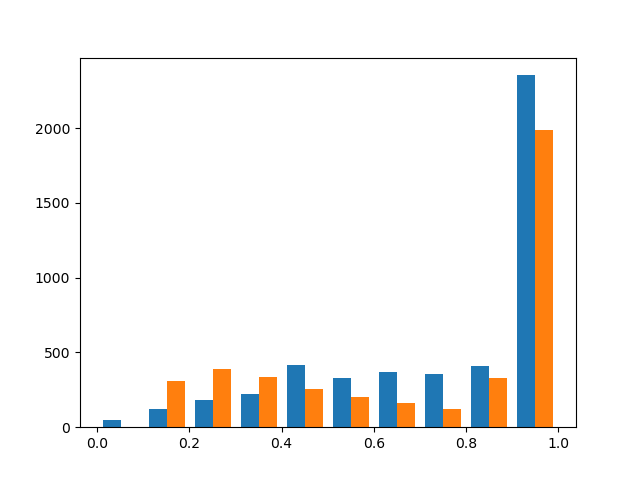

In [60]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.hist((tr_confidence, AML_confidence))
pass

In [61]:
prepare_submission(AML_y, "seb")

11.16.18.17_seb.csv
